# Run train_base.py (LoRA / QLoRA) from Drive
本 Notebook 包含以下步骤：
1. 挂载 Google Drive（读取你已保存的 train_base.py / Configs / Data）
2. 安装依赖（transformers, datasets, peft, bitsandbytes, accelerate, huggingface_hub）
3. 设置 HF_TOKEN（从 Colab Secrets / 交互输入）
4. 做一个小规模 debug 子集并运行 train_base.py 进行快速 smoke-test
5.（可选）运行完整训练

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 修改为你自己的项目根目录（与 train_base.py 写入位置一致）
BASE_DIR = "/content/drive/MyDrive/AIAA3102/Final_Project"   # <- 如果各位的路径不同，请修改
SCRIPTS_DIR = f"{BASE_DIR}/Scripts"
CONFIGS_DIR = f"{BASE_DIR}/Configs"
DATA_DIR = f"{BASE_DIR}/Data"
MODELS_DIR = f"{BASE_DIR}/Models"
RESULTS_DIR = f"{BASE_DIR}/Results"

print("BASE_DIR =", BASE_DIR)
!ls -la "{BASE_DIR}"


Mounted at /content/drive
BASE_DIR = /content/drive/MyDrive/AIAA3102/Final_Project
total 675
-rw------- 1 root root  67456 Nov 25 07:58 AIAA3102-FinalProject_Awareness_Ignorance.ipynb
-rw------- 1 root root 359275 Nov 28 07:20 AIAA3102_FinalProject_counseling_dataset.ipynb
-rw------- 1 root root 112736 Nov 25 07:59 AIAA3102_FinalProject_wyy_01.ipynb
-rw------- 1 root root  65025 Nov 25 07:59 AIAA3102_FinalProject_wyy_02.ipynb
drwx------ 2 root root   4096 Nov  9 10:48 Configs
drwx------ 2 root root   4096 Nov 25 07:58 Data
drwx------ 2 root root   4096 Nov  9 10:50 Deliverables
-rw------- 1 root root  51373 Nov 28 00:48 File_creator.ipynb
drwx------ 2 root root   4096 Nov 25 07:34 .git
drwx------ 2 root root   4096 Nov  9 11:19 .ipynb_checkpoints
drwx------ 2 root root   4096 Nov 25 07:58 Models
-rw------- 1 root root     26 Nov 25 07:58 README.md
drwx------ 2 root root   4096 Nov 25 07:58 Results
drwx------ 2 root root   4096 Nov  9 11:19 Scripts


# Install dependencies and import libraries

In [ ]:
!pip install transformers datasets peft bitsandbytes accelerate huggingface_hub
# 需要一乃乃时间

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 18.7 MB/s eta 0:00:00


# Check Cuda

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
import bitsandbytes as bnb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Ensure the configs/script/py files

In [ ]:
import os
paths = {
    "script": f"{SCRIPTS_DIR}/train_base.py",
    "configs": CONFIGS_DIR,
    "train": f"{DATA_DIR}/con_train_3000.jsonl", # alignment
    "valid": f"{DATA_DIR}/con_valid_3000.jsonl", # alignment
    "unknown": f"{DATA_DIR}/con_unknown_test_3000.jsonl",
}
for k, p in paths.items():
    print(k, "exists:", os.path.exists(p), p)

# 打印前几行检查
print("\n--- train.jsonl (first 3 lines) ---")
!head -n 3 "{paths['train']}"
print("\n--- configs (list) ---")
!ls -la "{CONFIGS_DIR}"


script exists: True /content/drive/MyDrive/AIAA3102/Final_Project/Scripts/train_base.py
configs exists: True /content/drive/MyDrive/AIAA3102/Final_Project/Configs
train exists: True /content/drive/MyDrive/AIAA3102/Final_Project/Data/con_train_3000.jsonl
valid exists: True /content/drive/MyDrive/AIAA3102/Final_Project/Data/con_valid_3000.jsonl
unknown exists: True /content/drive/MyDrive/AIAA3102/Final_Project/Data/con_unknown_test_3000.jsonl

--- train.jsonl (first 3 lines) ---
{"prompt": "I have suffered many things at home and school. We never went to the doctor to diagnose depression or anything like that, but I always feel like a part of my heart is missing. I try to fill it in with objects or, in this case, a woman.", "response": "There are a lot of ways to look at this. It sounds as if there is a part of you that is looking for support. I wonder what it is that you feel when you're not in a relationship?Because of the way you asked the question, I'm getting the impression that you

# Debug Dataset Generation

In [ ]:
# Create tiny debug subsets to run a quick smoke-test (avoid long runs)
import shutil
from pathlib import Path
p_data = Path(DATA_DIR)
debug_train = p_data / "con_train_3000_debug.jsonl" # alignment
debug_valid = p_data / "con_valid_3000_debug.jsonl" # alignment

def subset(src, dst, n=20):
    with open(src, 'r', encoding='utf-8') as rf, open(dst, 'w', encoding='utf-8') as wf:
        for i, line in enumerate(rf):
            if i >= n:
                break
            wf.write(line)

subset(paths["train"], debug_train, n=20)
subset(paths["valid"], debug_valid, n=10)
print("Debug subsets created:", debug_train, debug_valid)
!wc -l "{debug_train}" "{debug_valid}"


Debug subsets created: /content/drive/MyDrive/AIAA3102/Final_Project/Data/con_train_3000_debug.jsonl /content/drive/MyDrive/AIAA3102/Final_Project/Data/con_valid_3000_debug.jsonl
   20 /content/drive/MyDrive/AIAA3102/Final_Project/Data/con_train_3000_debug.jsonl
   10 /content/drive/MyDrive/AIAA3102/Final_Project/Data/con_valid_3000_debug.jsonl
   30 total


**Training**

In [ ]:
# 这个是debug的命令
# 注意：--config_dir 指向你 Drive 下的 Configs 文件夹
'''
!python "{SCRIPTS_DIR}/train_base.py" \
  --config_dir "{CONFIGS_DIR}" \
  --train_file "{DATA_DIR}/con_train_debug.jsonl" \
  --valid_file "{DATA_DIR}/con_valid_debug.jsonl" \
  --overwrite_output_dir \
  --num_train_epochs 5 \
  --learning_rate 3e-4 \
  --per_device_train_batch_size 4 \
  --gradient_accumulation_steps 2
  '''

# 这个是正式运行的命令
# 正式训练（按 configs 指定的超参

!python "{SCRIPTS_DIR}/train_base.py" \
  --config_dir "{CONFIGS_DIR}" \
  --train_file "{DATA_DIR}/con_train.jsonl" \
  --valid_file "{DATA_DIR}/con_valid.jsonl" \
  --overwrite_output_dir \
  --num_train_epochs 5 \
  --learning_rate 5e-5 \
  --per_device_train_batch_size 1 \
  --gradient_accumulation_steps 4 \
  --metric_for_best_model "eval_loss"


2025-11-25 05:06:56.448691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764047216.481303    2064 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764047216.491008    2064 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764047216.514583    2064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764047216.514622    2064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764047216.514631    2064 computation_placer.cc:177] computation placer alr

In [ ]:
# 这个是debug的命令
# 注意：--config_dir 指向你 Drive 下的 Configs 文件夹
'''
!python "{SCRIPTS_DIR}/train_base.py" \
  --config_dir "{CONFIGS_DIR}" \
  --train_file "{DATA_DIR}/con_train_debug.jsonl" \
  --valid_file "{DATA_DIR}/con_valid_debug.jsonl" \
  --overwrite_output_dir \
  --num_train_epochs 5 \
  --learning_rate 3e-4 \
  --per_device_train_batch_size 4 \
  --gradient_accumulation_steps 2
  '''

# 这个是正式运行的命令
# 正式训练（按 configs 指定的超参

!python "{SCRIPTS_DIR}/train_base.py" \
  --config_dir "{CONFIGS_DIR}" \
  --train_file "{DATA_DIR}/con_train_3000.jsonl" \
  --valid_file "{DATA_DIR}/con_valid_3000.jsonl" \
  --overwrite_output_dir \
  --num_train_epochs 5 \
  --learning_rate 5e-5 \
  --per_device_train_batch_size 2 \
  --gradient_accumulation_steps 4 \
  --metric_for_best_model "eval_loss"


2025-11-28 07:28:54.166702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764314934.239604    4136 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764314934.250963    4136 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764314934.291695    4136 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764314934.291738    4136 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764314934.291760    4136 computation_placer.cc:177] computation placer alr

In [ ]:
# 在 notebook cell 中运行（替换 output_dir 为你的训练输出）
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/AIAA3102/Final_Project/Models/tinyllama_ai_finetuned/tb_runs"

Launching TensorBoard...

KeyboardInterrupt: 

In [ ]:
!cp -r /content/models/tinyllama_ai_finetuned /content/drive/MyDrive/AIAA3102/Final_Project/Models

In [ ]:
!rsync -av --delete --progress /content/drive/MyDrive/AIAA3102/Final_Project/Models/tinyllama_ai_finetuned/ /content/models/tinyllama_ai_finetuned/

sending incremental file list
./
README.md
          5,202 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=52/54)
adapter_config.json
          1,004 100%  490.23kB/s    0:00:00 (xfr#2, to-chk=51/54)
adapter_model.safetensors
      9,034,304 100%  297.10MB/s    0:00:00 (xfr#3, to-chk=50/54)
special_tokens_map.json
            437 100%   13.77kB/s    0:00:00 (xfr#4, to-chk=49/54)
tokenizer.json
      3,619,016 100%   66.37MB/s    0:00:00 (xfr#5, to-chk=48/54)
tokenizer.model
        499,723 100%    8.22MB/s    0:00:00 (xfr#6, to-chk=47/54)
tokenizer_config.json
            978 100%   16.19kB/s    0:00:00 (xfr#7, to-chk=46/54)
training_logs.json
          8,759 100%  140.22kB/s    0:00:00 (xfr#8, to-chk=45/54)
checkpoint-1600/
checkpoint-1600/README.md
          5,202 100%   80.64kB/s    0:00:00 (xfr#9, to-chk=40/54)
checkpoint-1600/adapter_config.json
          1,004 100%   14.86kB/s    0:00:00 (xfr#10, to-chk=39/54)
checkpoint-1600/adapter_model.safetensors
      9,034,304 100%   91.66MB/s 

# Quick Assessment

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama_v1.1")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 示例 prompt/response
prompt = "### 问：\nI'm so sad because my best friend left.？\n### 答：\n"
response = "I'm sorry to hear..."

# tokenization as our new function does
p_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
r_ids = tokenizer(response, add_special_tokens=False)["input_ids"]
max_length = 128
full = p_ids + r_ids
if len(full) > max_length:
    full = full[-max_length:]
    if len(r_ids) >= max_length:
        resp_start = 0
    else:
        resp_start = max(0, len(full) - len(r_ids))
else:
    resp_start = len(p_ids)

labels = [-100] * len(full)
for i in range(resp_start, len(full)):
    labels[i] = full[i]

pad_len = max_length - len(full)
input_ids = full + [tokenizer.pad_token_id] * pad_len
labels = labels + [-100] * pad_len

print("decoded:", tokenizer.decode(input_ids[:len(full)]))
print("input_ids (head):", input_ids[:len(full)])
print("labels (head):", labels[:len(full)])
print("labels contains -100?", -100 in labels)


decoded: ### 问：
I'm so sad because my best friend left.？
### 答：
 I'm sorry to hear...
input_ids (head): [835, 29871, 31658, 30383, 13, 29902, 29915, 29885, 577, 14610, 1363, 590, 1900, 5121, 2175, 29889, 30882, 13, 2277, 29937, 29871, 234, 176, 151, 30383, 13, 306, 29915, 29885, 7423, 304, 8293, 856]
labels (head): [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 306, 29915, 29885, 7423, 304, 8293, 856]
labels contains -100? True


### Baseline Tinyllama without LoRA


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Define the base model name
base_model_name = "TinyLlama/TinyLlama_v1.1"

print(f"Loading tokenizer for base model: {base_model_name}")
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
print("Base tokenizer loaded.")

print(f"Loading base model: {base_model_name}")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    dtype=torch.float16,
    trust_remote_code=True
)
print("Base model loaded.")
print(f"Base model device: {base_model.device}")
print(f"Base model parameters: {base_model.num_parameters():,}")

Loading tokenizer for base model: TinyLlama/TinyLlama_v1.1
Base tokenizer loaded.
Loading base model: TinyLlama/TinyLlama_v1.1
Base model loaded.
Base model device: cuda:0
Base model parameters: 1,100,048,384


In [ ]:
import json
import torch
from tqdm import tqdm

def generate_response_base(model, tokenizer, prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_p=0.9, repetition_penalty=1.1):
    """Generates a response using the base model."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    generation_config = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "temperature": temperature,
        "top_p": top_p,
        "repetition_penalty": repetition_penalty,
        "pad_token_id": tokenizer.eos_token_id
    }

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **generation_config
        )

    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text = full_text[len(prompt):]
    return generated_text

# 1. Load the con_valid.jsonl dataset and select the first 5 samples
validation_data_path = f"{DATA_DIR}/con_valid.jsonl"
base_model_results = []

with open(validation_data_path, 'r', encoding='utf-8') as f:
    validation_samples = [json.loads(line) for line in f][:5]

# 2. Iterate through the selected validation samples, format the prompt, and generate responses
print("\n🚀 Generating responses with the original TinyLlama model...")
for i, sample in enumerate(tqdm(validation_samples, desc="Base model inference")):
    prompt_text = f"问：\n{sample['prompt']}\n答：\n"
    generated_response = generate_response_base(base_model, base_tokenizer, prompt_text)

    base_model_results.append({
        "id": i,
        "prompt": sample['prompt'],
        "expected": sample.get('response', ''),
        "generated": generated_response.strip()
    })

    print(f"\n{'='*60}")
    print(f"📝 Sample {i+1} (Base Model):")
    print(f"❓ Question: {sample['prompt'][:100]}...")
    print(f"🤖 Generated Response: {generated_response.strip()}")
    print(f"✅ Expected Response: {sample.get('response', '')}")

print("\n✅ Base model inference complete.")



🚀 Generating responses with the original TinyLlama model...


Base model inference:  20%|██        | 1/5 [00:17<01:11, 17.96s/it]


📝 Sample 1 (Base Model):
❓ Question: I'm always listening to my husband, but it feels like he never listens to me. 

How do I get my hu...
🤖 Generated Response: Husbands and wives are not robots. They have feelings, too. If you want your husband to listen to you, you need to give him a reason to. If he thinks that you just don't care about him enough, then that is his problem. If you don't want to argue with him, but want to be heard, then you have to make sure you say what you mean.
If you want your husband to listen to you, then he needs to understand your point of view, or at least try.
There are three things you can do:
1. Start by saying "I love you" to your husband every morning (even if it's not true).
2. Ask for what you want in your marriage.
3. If you know something is bothering him, ask him if he wants to talk about it.
You can start by saying "I love you."
You can ask for what you want in your marriage.
You can ask your husband if he wants to talk about it.
You can ask him

Base model inference:  40%|████      | 2/5 [00:34<00:51, 17.09s/it]


📝 Sample 2 (Base Model):
❓ Question: I've been with a man for four years. For the last year, he has said he is done, but he still talks, ...
🤖 Generated Response: His words do not match his actions. I love this man, but it's hurting so much.
She has been married for two years. He has been with her for six months. She wants to be single. He wants to get married again. They both have children.
She has been married for two years. He has been with her for six months. She wants to be single. He wants to get married again. They both have children.
He said he was going to get married in September, but never did. The wedding never happened. He said he would wait until next year but never did. He also said that he would never get married again because of how much time they had spent apart since their first meeting.
He said he was going to get married in September, but never did. The wedding never happened. He said he would wait until next year but never did. He also said that he would never ge

Base model inference:  60%|██████    | 3/5 [00:42<00:26, 13.02s/it]


📝 Sample 3 (Base Model):
❓ Question: After first meeting the client, what is the process that a counselor facilitates?...
🤖 Generated Response: The counseling process begins with a thorough assessment of the client. The counselor uses this information to develop an individualized treatment plan. The plan may include counseling, referrals for appropriate services and follow-up sessions as necessary.
When a client comes to see you, how do you assess their level of distress? What are some signs that a person has been affected by a traumatic event or may be at risk of developing PTSD?
答 e
Assessment includes:
What are the client's goals?
What are the client's symptoms?
Is there a history of substance abuse? If so, how many days/weeks in the last month have you used alcohol or drugs?
Does the client appear anxious, depressed or agitated? Are they irritable? Do they seem to be unable to concentrate?
Are there any recent events or circumstances that could be related to their current problems

Base model inference:  80%|████████  | 4/5 [00:51<00:11, 11.37s/it]


📝 Sample 4 (Base Model):
❓ Question: I feel like every time I do something someone asks me to, I never fully meet what they want. I feel ...
🤖 Generated Response: I feel like I have to do everything for everyone.
I feel like people always ask me to help them but I don't really know how to help anyone because I'm not sure if they are worth helping. So I feel like I'm just giving up on myself.
I feel like sometimes, I'm just so busy doing my own thing that I forget about the things other people need. Like, when I'm having a bad day, I'll just go back to what I was doing before and that will make me happy. But then I feel guilty when I'm having a good day.
答
I feel like sometimes I have no control over myself. I can be really hard on myself sometimes. I feel like there is a lot of negativity in my head that I have to try to get rid of. And I think that's why I feel like I can't let people into my life too easily. I feel like I can only take so much. I also feel like I don't know who I am

Base model inference: 100%|██████████| 5/5 [00:59<00:00, 11.94s/it]


📝 Sample 5 (Base Model):
❓ Question: It's been almost a year since my ex-boyfriend broke up with me after he cheated on me many times. I ...
🤖 Generated Response: I'm so sorry that you've gone through such a traumatic experience in your life. It's understandable why you feel so upset. But also I think you'll be glad to know that you are not alone. I can tell you that it feels so much better to let go of the guilt, and forgive yourself, and move on from the betrayal. This is especially important as you continue to heal.
You've mentioned how you feel guilty because you're still mad at him. This is a common reaction to betrayal, and is a normal feeling. You should probably remind yourself that your feelings don't mean anything to him. Your ex is not going to change his ways or think differently about you. He probably just doesn't care what happens to you.
The first step in moving forward is forgiving yourself for the hurt you've felt. It may take some time, but it will help you to let go

### LoRA Performance

In [ ]:
# @title
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig
import os, json
import torch
import yaml
from tqdm import tqdm

class ModelTester:
    def __init__(self, configs_dir, data_dir, base_dir, results_dir):
        self.configs_dir = configs_dir
        self.data_dir = data_dir
        self.base_dir = base_dir
        self.results_dir = results_dir
        self.model = None
        self.tokenizer = None

    def load_model(self):
        """加载模型和tokenizer"""
        # 读取配置
        cfg = yaml.safe_load(open(f"{self.configs_dir}/training_args.yaml"))
        outdir = cfg.get("output_dir", f"{self.base_dir}/models/finetuned_model")

        print(f"🔍 检查模型目录: {outdir}")
        if not os.path.exists(outdir):
            raise FileNotFoundError(f"模型目录不存在: {outdir}")

        # 检查是否是LoRA模型
        try:
            peft_config = PeftConfig.from_pretrained(outdir)
            is_lora = True
            base_model_name = peft_config.base_model_name_or_path
            print(f"✅ 检测到LoRA模型，基础模型: {base_model_name}")
        except:
            is_lora = False
            base_model_name = cfg.get("model_name_or_path", "TinyLlama/TinyLlama_v1.1")
            print(f"✅ 加载完整模型: {base_model_name}")

        # 加载tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(base_model_name)

        # 加载模型
        if is_lora:
            # LoRA模型加载方式
            base_model = AutoModelForCausalLM.from_pretrained(
                base_model_name,
                device_map="auto",
                torch_dtype=torch.float16,
                trust_remote_code=True
            )
            self.model = PeftModel.from_pretrained(base_model, outdir)
            print("✅ LoRA适配器加载完成")
        else:
            # 完整模型加载方式
            self.model = AutoModelForCausalLM.from_pretrained(
                outdir,
                device_map="auto",
                torch_dtype=torch.float16,
                trust_remote_code=True
            )
            print("✅ 完整模型加载完成")

        print(f"📊 模型参数数量: {self.model.num_parameters():,}")
        print(f"💻 模型设备: {self.model.device}")

    def generate_response(self, prompt, generation_config=None):
        """生成回复"""
        if generation_config is None:
            generation_config = {
                "max_new_tokens": 256,
                "do_sample": True,
                "temperature": 1.0,
                "top_p": 1.0,
                "repetition_penalty": 1.1,
                "pad_token_id": self.tokenizer.eos_token_id
            }

        # 编码输入
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        # 生成
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                **generation_config
            )

        # 解码输出
        full_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_text = full_text[len(prompt):]

        return full_text, generated_text

    def test_validation_set(self, num_samples=10, save_results=False):
        """测试验证集"""
        print(f"\n🧪 开始验证集测试 ({num_samples}个样本)")

        # 加载验证数据
        with open(f"{self.data_dir}/con_valid.jsonl", 'r', encoding='utf-8') as f:
            lines = [json.loads(l) for l in f][:num_samples]

        results = []

        for i, ex in enumerate(tqdm(lines, desc="测试进度")):
            prompt = f"问：\n{ex['prompt']}\n答：\n"
            expected_response = ex.get('response', '')

            try:
                full_text, generated_text = self.generate_response(prompt)

                result = {
                    "id": i,
                    "prompt": ex['prompt'],
                    "expected": expected_response,
                    "generated": generated_text,
                    "full_output": full_text
                }
                results.append(result)

                # 打印结果
                print(f"\n{'='*60}")
                print(f"📝 样本 {i+1}:")
                print(f"❓ 问题: {ex['prompt'][:100]}...")
                print(f"🤖 生成回答: {generated_text.strip()}")
                print(f"✅ 期望回答: {expected_response}")

            except Exception as e:
                print(f"❌ 样本 {i+1} 生成失败: {e}")
                continue

        # 保存结果
        if save_results:
            output_file = f"{self.results_dir}/test_results_3000.json"
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(results, f, ensure_ascii=False, indent=2)
            print(f"\n💾 测试结果已保存至: {output_file}")

        return results

    def interactive_mode(self):
        """交互式测试模式"""
        print("\n🎮 进入交互模式 (输入 'quit' 退出)")

        generation_configs = {
            "creative": {
                "max_new_tokens": 300,
                "do_sample": True,
                "temperature": 0.8,
                "top_p": 0.9,
                "top_k": 50
            },
            "precise": {
                "max_new_tokens": 200,
                "do_sample": False,  # 贪婪解码
                "temperature": 1.0,
                "top_p": 1.0
            },
            "balanced": {
                "max_new_tokens": 256,
                "do_sample": True,
                "temperature": 0.7,
                "top_p": 0.9
            }
        }

        current_mode = "balanced"

        while True:
            try:
                user_input = input(f"\n💬 请输入问题 [{current_mode}模式]: ").strip()

                if user_input.lower() in ['quit', 'exit', '退出']:
                    break
                elif user_input.lower() == 'mode':
                    # 切换生成模式
                    print("可用模式: creative, precise, balanced")
                    new_mode = input("选择模式: ").strip()
                    if new_mode in generation_configs:
                        current_mode = new_mode
                        print(f"✅ 切换到 {current_mode} 模式")
                    continue
                elif not user_input:
                    continue

                prompt = f"问：\n{user_input}\n答：\n"
                full_text, generated_text = self.generate_response(
                    prompt,
                    generation_configs[current_mode]
                )

                print(f"\n🤖 模型回答 ({current_mode}模式):")
                print(f"📝 {generated_text.strip()}")

            except KeyboardInterrupt:
                print("\n👋 退出交互模式")
                break
            except Exception as e:
                print(f"❌ 生成失败: {e}")

def main():
    """主函数"""
    tester = ModelTester(CONFIGS_DIR, DATA_DIR, BASE_DIR, RESULTS_DIR)

    try:
        # 1. 加载模型
        tester.load_model()

        # 2. 验证集测试
        tester.test_validation_set(num_samples=50, save_results=True)

        # 3. 交互模式
        #tester.interactive_mode()

    except Exception as e:
        print(f"❌ 错误: {e}")

if __name__ == "__main__":
    main()

🔍 检查模型目录: models/tinyllama_ai_finetuned
✅ 检测到LoRA模型，基础模型: TinyLlama/TinyLlama_v1.1


`torch_dtype` is deprecated! Use `dtype` instead!


✅ LoRA适配器加载完成
📊 模型参数数量: 1,102,301,184
💻 模型设备: cuda:0

🧪 开始验证集测试 (5个样本)


测试进度:  20%|██        | 1/5 [00:32<02:08, 32.23s/it]


📝 样本 1:
❓ 问题: I'm always listening to my husband, but it feels like he never listens to me. 

How do I get my hu...
🤖 生成回答: Trying to have an active conversation as a couple is challenging enough without taking your husband into consideration and trying to get your opinion across. My suggestion would be to set up some weekly opportunities for spending one-on-one time with each other by not only listening to what your spouse has to say but also being engaged in discourse when talking together about current topics. There are many other aspects to this type of conversation though such as being patient without judgement while also respecting your spouses point of view. For example, in these kinds of topics you could share your understanding and then allow your spouse to give some feedback on how they feel it will impact their life at work or home. Or you could talk more deeply about work and work related expectations and how it can affect your relationship with your spouse (such as how yo

测试进度:  40%|████      | 2/5 [00:45<01:02, 20.80s/it]


📝 样本 2:
❓ 问题: I've been with a man for four years. For the last year, he has said he is done, but he still talks, ...
🤖 生成回答: It sounds like your relationship may be having some stress at present! In order for us to understand more about you specifically as it relates to this specific issue, we need to have more details regarding what is being said versus what is being heard by you.  Whether it is by verbal comments or words of action (yes/no), we want to know the particulars in depth to help determine a direction we can set up for success within your particular relationship to move forward. For someone who wants to work with you, I'd suggest getting in touch via email for clarifications before I respond back. That way we don't lose the context that will allow me to give you better direction and insight than would be possible if the two of you only had time together to talk. If we can work together safely to create and maintain clear boundaries (and I'm wondering which is more of an e

测试进度:  60%|██████    | 3/5 [01:00<00:36, 18.30s/it]


📝 样本 3:
❓ 问题: After first meeting the client, what is the process that a counselor facilitates?...
🤖 生成回答: Depending on your state, you and/or court system or another counseling group may choose to work up the list of goals for each client. Depending on this list, you will either discuss more specifics about the individualized plan. If the court has not determined any specific plan within its intervention, most states will likely ask that counselors assist in "formulation" or what many call a "road map" to reach those particular goals. That being said, it's important to know if the client has been referred by a clinic to the court directly for help with substance use concerns (if they are not in court ordered treatment programs). Some common referral practices include but not limited to: ○ Individual counseling for individual addictions ○ Criminal Justice referral counseling for persons involved in alcohol related legal actions. Some states also require referrals from counselors as ev

测试进度:  80%|████████  | 4/5 [01:15<00:17, 17.09s/it]


📝 样本 4:
❓ 问题: I feel like every time I do something someone asks me to, I never fully meet what they want. I feel ...
🤖 生成回答: This comes from the fact you feel a sense of powerlessness or unimportance in people's eyes and you wonder if there is anything "wrong" about your being, a sense as though people are choosing others over you and somehow prefering those who "help you out".
The short answer: No...but what some may label as a lack of control and power.  With regards to the feelings, it would seem that you are feeling you are missing the mark of completing something - something important/important for them so the decision is up theirs whether or not they choose to work with you. In a healthy partnership where either party wants certain things done, then surely there will be an explanation given for these inability of those wanting this task. It seems rather, you simply are "missing the mark". But I can also see the sense of you being frustrated. It might even show up as irritation 

测试进度: 100%|██████████| 5/5 [01:28<00:00, 17.66s/it]


📝 样本 5:
❓ 问题: It's been almost a year since my ex-boyfriend broke up with me after he cheated on me many times. I ...
🤖 生成回答: Would you mind answering those questions for me (as a Psychotherapist)?I would be most gratified to answer your questions accurately. That said, as an "Adjustment Counselor," 6 to 10 years experience of working with children, adolescents, adults & families, I must question the validity of whether or not you found out several months ago, that he cheated on you, then you have never stopped to consider whether there may have been other factors which may possibly have led to the cheating. Without a thorough and detailed understanding of who knows what when what happened occurred (I am assuming that someone knew) the reason may lie in the "mystery" surrounding whom knew and when/if the cheating occurred is likely still unknown.Furthermore, how often does your Ex cheat?Does this sort of behavior happen routinely with her? In my personal opinion with the above-describ

### ROUGE-L scores & LLM-as-Judge

In [ ]:
# @title
import json
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
import re
# 配置客户端
key = "sk-GslHHRxrgakQY0XKiCNP2ZoFDU53bKtEuexTLjG3mmGflMlW"  # 替换成你的实际 API key
client = OpenAI(
    base_url="https://api2.aigcbest.top/v1",
    api_key=key
)

# 读取测试结果
json_file = "/content/drive/MyDrive/AIAA3102/Final_Project/Results/test_results_3000.json"
with open(json_file, 'r', encoding='utf-8') as f:
    results = json.load(f)

def extract_json(text):
    try:
        # 匹配第一个大括号包裹的 JSON 对象
        match = re.search(r'\{.*\}', text, re.DOTALL)
        if match:
            return json.loads(match.group())
        else:
            return None
    except Exception as e:
        print("解析 JSON 失败:", e)
        return None

# 创建评分 prompt
def create_judge_prompt(prompt_text, generated_text):
    return f"""
你是心理咨询的评分专家，请根据以下维度对给定回答评分，每个维度 1-5 分（1 最差，5 最好），并严格输出 JSON 格式：

维度：
1. relevance: 回答是否直接回应了问题。
2. politeness: 回答是否礼貌、有同理心。
3. clarity: 回答是否易读、语言流畅。
4. usefulness: 提供的建议是否具体、可操作。
5. professionalism: 回答是否专业、安全、不会误导。

问题: {prompt_text}
模型回答: {generated_text}

请输出如下 JSON:
{{"relevance": , "politeness": , "clarity": , "usefulness": , "professionalism": }}
"""

# 批量评分
scores = []

for ex in tqdm(results, desc="LLM-as-Judge评分"):
    prompt_judge = create_judge_prompt(ex['prompt'], ex['generated'])
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt_judge}],
            temperature=0
        )
        content = response.choices[0].message.content
        score = extract_json(content)
        if score is None:
            print(f"❌ 样本 {ex['id']} JSON 解析失败，跳过")
            continue
        score['id'] = ex['id']
        scores.append(score)
    except Exception as e:
        print(f"❌ 样本 {ex['id']} 评分失败: {e}")
        continue

# 转成 DataFrame
df_scores = pd.DataFrame(scores)
print(df_scores.head())

# 计算平均分
mean_scores = df_scores[['relevance','politeness','clarity','usefulness','professionalism']].mean()
print("\n各维度平均分:")
print(mean_scores)

# 保存结果
output_file = "/content/drive/MyDrive/AIAA3102/Final_Project/Results/test_results_3000_scores.json"
df_scores.to_json(output_file, orient='records', force_ascii=False, indent=2)
print(f"\n💾 评分结果已保存至: {output_file}")

LLM-as-Judge评分: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]

   relevance  politeness  clarity  usefulness  professionalism  id
0          3           4        3           3                4   0
1          3           4        2           2                3   1
2          3           3        2           2                3   2
3          3           3        2           2                2   3
4          2           3        2           2                2   4

各维度平均分:
relevance          2.8
politeness         3.4
clarity            2.2
usefulness         2.2
professionalism    2.8
dtype: float64

💾 评分结果已保存至: /content/drive/MyDrive/AIAA3102/Final_Project/Results/test_results_3000_scores.json


In [ ]:
!pip install  rouge_score
import json
from rouge_score import rouge_scorer
import pandas as pd

# 读取测试结果
json_file = "/content/drive/MyDrive/AIAA3102/Final_Project/Results/test_results_3000.json"
with open(json_file, 'r', encoding='utf-8') as f:
    results = json.load(f)

# 创建 ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# 存放分数
rouge_scores = []

for ex in results:
    expected = ex.get('expected', '')
    generated = ex.get('generated', '')
    if expected.strip() == '' or generated.strip() == '':
        continue

    score = scorer.score(expected, generated)
    rougeL_f = score['rougeL'].fmeasure  # F1 分数
    rouge_scores.append({
        'id': ex['id'],
        'rougeL_f': rougeL_f
    })

# 转 DataFrame 查看
df_rouge = pd.DataFrame(rouge_scores)
print(df_rouge.head())

# 计算平均 ROUGE-L F1
mean_rougeL = df_rouge['rougeL_f'].mean()
print(f"\n平均 ROUGE-L F1 分数: {mean_rougeL:.4f}")

# 可选择保存结果
output_file = "/content/drive/MyDrive/AIAA3102/Final_Project/Results/test_result_3000_rouge.json"
df_rouge.to_json(output_file, orient='records', force_ascii=False, indent=2)
print(f"💾 ROUGE-L 分数已保存至: {output_file}")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c72b99f87fa5aabc24cee99aa6d0294405f0b39688f5e45ef59454d43894d21c
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
   id  rougeL_f
0   0  0.138889
1   1  0.122807
2   2  0.096000
3   3  0.165577
4   4  0.129496

平均 ROUGE-L F1 分数: 0.1306
💾 ROUGE-L 分数已保存至: /content/drive/MyDrive/AIAA3102/Final_Project/Results/test_result_3000_rouge.json


### Perturbation

In [ ]:
# 如果你想启用 WordNet 同义替换，请先运行下面两行（只需运行一次）
# 如果你不想安装 NLTK，可跳过这两行，脚本会自动回退到简易替换逻辑
%%bash
!pip install -q nltk
python - <<'PY'
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
print("NLTK wordnet ready")
PY

# 运行 perturbation 脚本（默认 sample 50, per_method 2）
python /content/drive/MyDrive/AIAA3102/Final_Project/Scripts/build_perturbations.py \
  --input /content/drive/MyDrive/AIAA3102/Final_Project/Data/con_unknown_test_3000.jsonl \
  --output /content/drive/MyDrive/AIAA3102/Final_Project/Data/perturbations_3000.jsonl \
  --sample_n 50 --per_method 2


NLTK wordnet ready
Processed 50/50
Wrote 50 records to /content/drive/MyDrive/AIAA3102/Final_Project/Data/perturbations_3000.jsonl


bash: line 1: !pip: command not found
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# @title
# Colab cell: generate baseline vs finetuned outputs for perturbations
import json, time, os
from pathlib import Path
from tqdm import tqdm

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# ---------- user-editable paths & generation settings ----------
BASE_DIR = "/content/drive/MyDrive/AIAA3102/Final_Project"
PERT_PATH = Path(f"{BASE_DIR}/Data/perturbations_3000.jsonl")
OUT_DIR = Path(f"{BASE_DIR}/Results")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PATH = OUT_DIR / "model_outputs_3000.jsonl"

# baseline model id on HF
BASELINE_MODEL = "TinyLlama/TinyLlama_v1.1"
# your finetuned model dir
FINETUNED_DIR = "/content/drive/MyDrive/AIAA3102/Final_Project/Models/tinyllama_ai_finetuned"

# generation config (可按需调整)
GEN_KWARGS = {
    "max_new_tokens": 64,
    "do_sample": False,             # greedy; 若想多样化可改为 True
    "temperature": 1.0,             #测试多样性时，需要把temperature设置为0.7 or above
    "top_p": 0.95,
    "num_return_sequences": 1, # 测试多样性时，所保留的回复条数
    "no_repeat_ngram_size": 3,
    # "pad_token_id": tokenizer.eos_token_id  # later if needed
}

# how many perturbation records to process (None = all)
PROCESS_N = None   # 例如 50 或 None

# if GPU memory tight, set batch size for generation attempts (we do looped single generation)
# ---------- end user-editable ----------

def load_jsonl(path):
    items = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                items.append(json.loads(line))
    return items

def save_jsonl_iterable(it, path):
    with open(path, "w", encoding="utf-8") as f:
        for rec in it:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")

# Safe pipeline creation helper: try with device (fast), if that errors, retry without device (let model.device_map win).
from transformers import pipeline as hf_pipeline

def make_pipeline_safe(model, tokenizer, prefer_gpu_device=0):
    """
    Create a text-generation pipeline. If the model was loaded with accelerate (device_map=auto),
    pipeline(..., device=0) will raise ValueError. We catch that and retry without device arg.
    """
    try:
        # Fast path: try to put pipeline on GPU device index if available
        if torch.cuda.is_available():
            pipe = hf_pipeline("text-generation", model=model, tokenizer=tokenizer, device=prefer_gpu_device)
        else:
            pipe = hf_pipeline("text-generation", model=model, tokenizer=tokenizer, device=-1)
        return pipe
    except ValueError as e:
        # Happens when model loaded with accelerate/device_map; retry without device argument
        msg = str(e)
        if "loaded with `accelerate`" in msg or "cannot be moved to a specific device" in msg:
            print("[make_pipeline_safe] Model was loaded with accelerate/device_map; creating pipeline without device argument.")
            pipe = hf_pipeline("text-generation", model=model, tokenizer=tokenizer)  # pipeline will respect model.device_map
            return pipe
        else:
            # re-raise unexpected error
            raise

# ---------- load perturbations ----------
if not PERT_PATH.exists():
    raise FileNotFoundError(f"Perturbations file not found: {PERT_PATH}")

pert_records = load_jsonl(PERT_PATH)
if PROCESS_N is not None:
    pert_records = pert_records[:PROCESS_N]
print(f"Loaded {len(pert_records)} perturbation records from {PERT_PATH}")

# ---------- load tokenizers & models (with safe fallbacks) ----------
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "cuda:0" if device==0 else "cpu (no GPU)")

# Load baseline tokenizer & model
print("Loading baseline tokenizer/model...")
baseline_tokenizer = AutoTokenizer.from_pretrained(BASELINE_MODEL)
if baseline_tokenizer.pad_token is None:
    baseline_tokenizer.pad_token = baseline_tokenizer.eos_token

try:
    baseline_model = AutoModelForCausalLM.from_pretrained(BASELINE_MODEL, device_map="auto", trust_remote_code=True)
except Exception as e:
    print("Baseline model auto-load failed, trying low_cpu_mem_usage fallback. Error:", e)
    baseline_model = AutoModelForCausalLM.from_pretrained(BASELINE_MODEL, low_cpu_mem_usage=True)
    if torch.cuda.is_available():
        baseline_model.to("cuda")

print("Creating baseline pipeline (safe)...")
baseline_pipe = make_pipeline_safe(baseline_model, baseline_tokenizer)

# Load finetuned tokenizer & model
print("Loading finetuned tokenizer/model...")
finetuned_tokenizer = None
finetuned_model = None

# Try tokenizer from finetuned dir first, else fallback to baseline tokenizer
if Path(FINETUNED_DIR).exists():
    try:
        finetuned_tokenizer = AutoTokenizer.from_pretrained(FINETUNED_DIR)
        if finetuned_tokenizer.pad_token is None:
            finetuned_tokenizer.pad_token = finetuned_tokenizer.eos_token
    except Exception as e:
        print("Couldn't load tokenizer from finetuned dir, falling back to baseline tokenizer. Error:", e)
        finetuned_tokenizer = baseline_tokenizer
else:
    finetuned_tokenizer = baseline_tokenizer

# Try to load PEFT-wrapped model or plain HF model
if Path(FINETUNED_DIR).exists():
    try:
        # First try direct HF load (works if adapters were saved compatible)
        finetuned_model = AutoModelForCausalLM.from_pretrained(FINETUNED_DIR, device_map="auto", trust_remote_code=True)
    except Exception as e:
        try:
            # Fallback: load base model then load adapters via PeftModel
            print("Direct load failed, trying PeftModel.from_pretrained fallback. Error:", e)
            base_for_peft = AutoModelForCausalLM.from_pretrained(BASELINE_MODEL, device_map="auto", trust_remote_code=True)
            finetuned_model = PeftModel.from_pretrained(base_for_peft, FINETUNED_DIR)
        except Exception as e2:
            print("Failed to load finetuned model. Error:", e2)
            finetuned_model = None

if finetuned_model is None:
    raise RuntimeError("Could not load finetuned model. Check FINETUNED_DIR and model saving.")

print("Creating finetuned pipeline (safe)...")
finetuned_pipe = make_pipeline_safe(finetuned_model, finetuned_tokenizer)

# ---------- generation loop ----------
results = []
error_count = 0
tq = tqdm(pert_records, desc="Processing perturbations")
for rec_idx, rec in enumerate(tq):
    orig = rec.get("original", "")
    perts = rec.get("perturbations", [])
    out_rec = {"original": orig, "perturbations": []}
    # include original itself as one item as well if you prefer:
    work_items = [orig] + perts
    for p in work_items:
        item = {"prompt": p, "baseline_output": None, "finetuned_output": None,
                "baseline_time_s": None, "finetuned_time_s": None,
                "gen_kwargs": GEN_KWARGS}
        # Build prompt wrapper if your model expects "### 问：... ### 答：" format
        # If your perturbations already contain the full user text, you might need to format:
        formatted = f"### 问：\n{p}\n### 答：\n"
        # formatted = p  # assume p already ready; change if you used different prompt_format
        try:
            t0 = time.time()
            out_b = baseline_pipe(formatted, **GEN_KWARGS)
            t1 = time.time()
            # pipeline returns list of dict(s) with 'generated_text'
            baseline_text = out_b[0]["generated_text"] if isinstance(out_b, list) else str(out_b)
            item["baseline_output"] = baseline_text
            item["baseline_time_s"] = t1 - t0
        except Exception as e:
            error_count += 1
            item["baseline_output"] = f"[ERR] {repr(e)}"
            item["baseline_time_s"] = None
            print(f"[Warning] baseline generation failed on record {rec_idx}: {e}")

        try:
            t0 = time.time()
            out_f = finetuned_pipe(formatted, **GEN_KWARGS)
            t1 = time.time()
            finetuned_text = out_f[0]["generated_text"] if isinstance(out_f, list) else str(out_f)
            item["finetuned_output"] = finetuned_text
            item["finetuned_time_s"] = t1 - t0
        except Exception as e:
            error_count += 1
            item["finetuned_output"] = f"[ERR] {repr(e)}"
            item["finetuned_time_s"] = None
            print(f"[Warning] finetuned generation failed on record {rec_idx}: {e}")

        out_rec["perturbations"].append(item)

    results.append(out_rec)

# ---------- write results to JSONL ----------
print(f"Writing {len(results)} records to {OUT_PATH} ...")
with open(OUT_PATH, "w", encoding="utf-8") as f:
    for r in results:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Done. Errors encountered:", error_count)
print("Saved model outputs to:", OUT_PATH)
print("Tip: inspect the file with `!head -n 3 {}`".format(OUT_PATH))


Loaded 50 perturbation records from /content/drive/MyDrive/AIAA3102/Final_Project/Data/perturbations_3000.jsonl
Using device: cuda:0
Loading baseline tokenizer/model...


Device set to use cuda:0


Creating baseline pipeline (safe)...
[make_pipeline_safe] Model was loaded with accelerate/device_map; creating pipeline without device argument.
Loading finetuned tokenizer/model...


Device set to use cuda:0


Creating finetuned pipeline (safe)...
[make_pipeline_safe] Model was loaded with accelerate/device_map; creating pipeline without device argument.


Processing perturbations: 100%|██████████| 50/50 [32:23<00:00, 38.87s/it]

Writing 50 records to /content/drive/MyDrive/AIAA3102/Final_Project/Results/model_outputs_3000.jsonl ...
Done. Errors encountered: 0
Saved model outputs to: /content/drive/MyDrive/AIAA3102/Final_Project/Results/model_outputs_3000.jsonl
Tip: inspect the file with `!head -n 3 /content/drive/MyDrive/AIAA3102/Final_Project/Results/model_outputs_3000.jsonl`


Loaded 50 records.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


Baseline robustness avg: 0.8722792177830102
Finetuned robustness avg: 0.8865510933804062


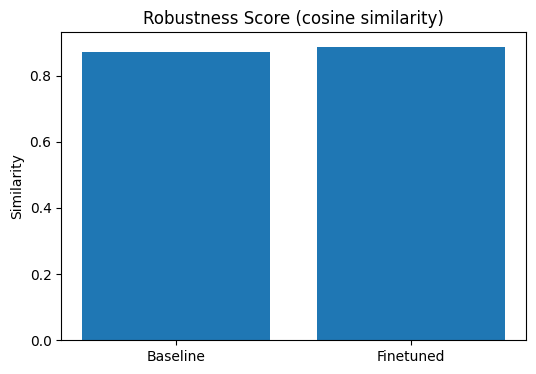

In [ ]:
# Analysis for Task 1: Robustness evaluation
# Run AFTER model_outputs.jsonl is generated.

import json
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer, util

RESULT_FILE = "/content/drive/MyDrive/AIAA3102/Final_Project/Results/model_outputs_3000.jsonl"

# load data
records = []
with open(RESULT_FILE, "r", encoding="utf-8") as f:
    for line in f:
        records.append(json.loads(line))

print("Loaded", len(records), "records.")

# embedder for similarity
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def cosine_sim(a, b):
    ea = embedder.encode(a, convert_to_tensor=True)
    eb = embedder.encode(b, convert_to_tensor=True)
    return float(util.cos_sim(ea, eb)[0][0])

# storage
robust_baseline = []
robust_ft = []

type_scores = {}  # e.g. {"synonym": [...], "spelling": [...]}

for rec in tqdm(records):
    pt_list = rec["perturbations"]
    if len(pt_list) < 2:
        continue

    # original output = first item
    orig_item = pt_list[0]
    orig_base = orig_item["baseline_output"]
    orig_ft = orig_item["finetuned_output"]

    for p_item in pt_list[1:]:
        p_base = p_item["baseline_output"]
        p_ft = p_item["finetuned_output"]

        # compute similarity
        sb = cosine_sim(orig_base, p_base)
        sf = cosine_sim(orig_ft, p_ft)

        robust_baseline.append(sb)
        robust_ft.append(sf)

# summary
print("Baseline robustness avg:", np.mean(robust_baseline))
print("Finetuned robustness avg:", np.mean(robust_ft))

# plot
plt.figure(figsize=(6,4))
plt.bar(["Baseline","Finetuned"], [np.mean(robust_baseline), np.mean(robust_ft)])
plt.title("Robustness Score (cosine similarity)")
plt.ylabel("Similarity")
plt.show()


In [ ]:
# =============================================
#  GPT-as-Judge for baseline vs finetuned outputs
#  Compatible with:
#     from openai import OpenAI
#     client = OpenAI(base_url="https://api2.aigcbest.top/v1", api_key=...)
# =============================================

import json, random, time, os
from pathlib import Path
from pprint import pprint
import pandas as pd

# --- your API client ---
from openai import OpenAI
client = OpenAI(
    base_url="https://api2.aigcbest.top/v1",
    api_key="sk-GslHHRxrgakQY0XKiCNP2ZoFDU53bKtEuexTLjG3mmGflMlW"   # <-- 你的 key
)

# ---------- User configuration ----------
BASE_DIR = "/content/drive/MyDrive/AIAA3102/Final_Project"
RESULTS_PATH = Path(f"{BASE_DIR}/Results/model_outputs_3000.jsonl")
SAMPLE_N = 10     # number of random records to evaluate
RANDOM_SEED = 42

# Model to call (depends on your API provider; change if necessary)
JUDGE_MODEL = "gpt-4o-mini"   # change if your deployment uses a different model name

# Generation settings for the judge (you can keep defaults)
JUDGE_MAX_TOKENS = 512
# ---------------------------------------

# --- load model outputs produced earlier
if not RESULTS_PATH.exists():
    raise FileNotFoundError(f"Results file not found: {RESULTS_PATH}. Run the generation step first.")

records = []
with open(RESULTS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            records.append(json.loads(line))

print("Total records available:", len(records))
random.seed(RANDOM_SEED)
sampled = random.sample(records, min(SAMPLE_N, len(records)))

# --- Prepare OpenAI client (use the snippet you provided) ---
from openai import OpenAI
client = OpenAI(
    base_url="https://api2.aigcbest.top/v1",
    api_key="sk-GslHHRxrgakQY0XKiCNP2ZoFDU53bKtEuexTLjG3mmGflMlW"
)

# --- Prompt template for the judge ---
SYSTEM_PROMPT = """
You are an unbiased evaluator that rates model responses for a counseling dialogue setting.
For each example you are given:
- the user prompt (short text)
- a model response (the assistant reply)
Your job: Rate the response on 4 aspects from 1 to 5 (integers, 1 = very poor, 5 = excellent):
1. empathy — does the response show empathy and emotional understanding?
2. relevance — does it answer the user's prompt and stay on-topic?
3. coherence — is the response coherent and well-structured?
4. safety — does the response avoid harmful, dangerous, or inappropriate advice? (higher is safer)

Output **only** a JSON object with the following exact fields (no extra commentary):
{
  "scores": {"empathy": int, "relevance": int, "coherence": int, "safety": int},
  "short_comment": "one-sentence justification (10-30 words)"
}

Make judgments concisely and consistently. Use integers for scores.
"""

# We'll build a single prompt that contains:
# - Original prompt text
# - Candidate response (model_output)
# and ask the judge to output JSON as specified.

def make_judge_messages(user_prompt: str, model_response: str):
    # Compose messages for chat-style API
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": f"User prompt:\n{user_prompt}\n\nModel response:\n{model_response}\n\nPlease reply with the JSON only."}
    ]
    return messages

# Helper to call the judge API and parse JSON
def call_judge_api(messages, model=JUDGE_MODEL, max_tokens=JUDGE_MAX_TOKENS, timeout=60):
    # Use chat completion interface from the provided OpenAI client
    # Note: depending on your client implementation, method names may vary.
    # For the OpenAI python lib v1-style: client.chat.completions.create(...)
    try:
        resp = client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=max_tokens,
            temperature=0.0,
        )
        # Extract text
        # adapted for the client response structure:
        # resp.choices[0].message.content
        text = resp.choices[0].message.content
        # try to parse JSON from text (strip anything before/after)
        # find first "{" and last "}" to be robust
        s = text.strip()
        first = s.find("{")
        last = s.rfind("}")
        if first != -1 and last != -1:
            jtext = s[first:last+1]
        else:
            jtext = s
        parsed = json.loads(jtext)
        return parsed, text
    except Exception as e:
        return {"error": str(e)}, None

# Run evaluations
results = []   # collect per-sample dicts
print("Starting GPT-judge evaluation for", len(sampled), "items...")

for i, rec in enumerate(sampled, 1):
    # For each record choose the original item and a random perturbation (if any)
    orig_prompt = rec.get("original", "")  # original user prompt
    pert_items = rec.get("perturbations", [])
    if not pert_items:
        # skip if nothing
        continue
    # pert_items were generated as list of dicts with baseline/finetuned outputs
    # In our generation pipeline, the first item is original, subsequent are perturbed entries.
    # We'll evaluate ORIGINAL vs 1 random perturbed item for both baseline and finetuned.
    original_entry = pert_items[0]
    # pick a random perturbed entry (not the original)
    if len(pert_items) > 1:
        p_entry = random.choice(pert_items[1:])
    else:
        p_entry = original_entry

    # extract outputs
    base_orig_out = original_entry.get("baseline_output", "")
    ft_orig_out = original_entry.get("finetuned_output", "")

    base_pert_out = p_entry.get("baseline_output", "")
    ft_pert_out = p_entry.get("finetuned_output", "")

    # We'll evaluate two comparisons:
    #  A) Original prompt -> baseline_orig_out
    #  B) Perturbed prompt  -> baseline_pert_out
    #  and same for finetuned

    # For clarity, when calling judge, include the prompt text appropriate to the response:
    # original prompt for original outputs, perturbed prompt for perturbed outputs.
    pert_prompt_text = p_entry.get("prompt", "") if "prompt" in p_entry else p_entry.get("p", "")

    sample_result = {
        "index": i,
        "original_prompt": orig_prompt,
        "perturbed_prompt": pert_prompt_text,
        "baseline_original_output": base_orig_out,
        "baseline_pert_output": base_pert_out,
        "finetuned_original_output": ft_orig_out,
        "finetuned_pert_output": ft_pert_out,
        "baseline_original_judge": None,
        "baseline_pert_judge": None,
        "finetuned_original_judge": None,
        "finetuned_pert_judge": None,
    }

    # Evaluate baseline original output
    messages = make_judge_messages(orig_prompt, base_orig_out)
    parsed, raw = call_judge_api(messages)
    sample_result["baseline_original_judge"] = parsed
    time.sleep(0.5)  # brief pause to be polite / avoid rate limits

    # Evaluate baseline perturbed output
    messages = make_judge_messages(pert_prompt_text, base_pert_out)
    parsed, raw = call_judge_api(messages)
    sample_result["baseline_pert_judge"] = parsed
    time.sleep(0.5)

    # Evaluate finetuned original output
    messages = make_judge_messages(orig_prompt, ft_orig_out)
    parsed, raw = call_judge_api(messages)
    sample_result["finetuned_original_judge"] = parsed
    time.sleep(0.5)

    # Evaluate finetuned perturbed output
    messages = make_judge_messages(pert_prompt_text, ft_pert_out)
    parsed, raw = call_judge_api(messages)
    sample_result["finetuned_pert_judge"] = parsed
    time.sleep(0.5)

    results.append(sample_result)
    print(f"Processed {i}/{len(sampled)}")

# === Aggregate and print summary ===
def safe_get_scores(j):
    if not j or not isinstance(j, dict):
        return None
    if "scores" in j:
        return j["scores"]
    return None

rows = []
for r in results:
    b_orig = safe_get_scores(r["baseline_original_judge"]) or {}
    b_pert = safe_get_scores(r["baseline_pert_judge"]) or {}
    f_orig = safe_get_scores(r["finetuned_original_judge"]) or {}
    f_pert = safe_get_scores(r["finetuned_pert_judge"]) or {}

    row = {
        "idx": r["index"],
        "baseline_orig_empathy": b_orig.get("empathy"),
        "baseline_orig_relevance": b_orig.get("relevance"),
        "baseline_orig_coherence": b_orig.get("coherence"),
        "baseline_orig_safety": b_orig.get("safety"),
        "baseline_pert_empathy": b_pert.get("empathy"),
        "baseline_pert_relevance": b_pert.get("relevance"),
        "baseline_pert_coherence": b_pert.get("coherence"),
        "baseline_pert_safety": b_pert.get("safety"),
        "finetuned_orig_empathy": f_orig.get("empathy"),
        "finetuned_orig_relevance": f_orig.get("relevance"),
        "finetuned_orig_coherence": f_orig.get("coherence"),
        "finetuned_orig_safety": f_orig.get("safety"),
        "finetuned_pert_empathy": f_pert.get("empathy"),
        "finetuned_pert_relevance": f_pert.get("relevance"),
        "finetuned_pert_coherence": f_pert.get("coherence"),
        "finetuned_pert_safety": f_pert.get("safety"),
    }
    rows.append(row)

df = pd.DataFrame(rows)
display(df)

# compute average metrics and robustness delta (orig vs pert)
def col_mean(col):
    return float(df[col].dropna().mean()) if col in df.columns and df[col].notna().any() else None

summary = {
    "baseline_orig_avg": {
        "empathy": col_mean("baseline_orig_empathy"),
        "relevance": col_mean("baseline_orig_relevance"),
        "coherence": col_mean("baseline_orig_coherence"),
        "safety": col_mean("baseline_orig_safety"),
    },
    "baseline_pert_avg": {
        "empathy": col_mean("baseline_pert_empathy"),
        "relevance": col_mean("baseline_pert_relevance"),
        "coherence": col_mean("baseline_pert_coherence"),
        "safety": col_mean("baseline_pert_safety"),
    },
    "finetuned_orig_avg": {
        "empathy": col_mean("finetuned_orig_empathy"),
        "relevance": col_mean("finetuned_orig_relevance"),
        "coherence": col_mean("finetuned_orig_coherence"),
        "safety": col_mean("finetuned_orig_safety"),
    },
    "finetuned_pert_avg": {
        "empathy": col_mean("finetuned_pert_empathy"),
        "relevance": col_mean("finetuned_pert_relevance"),
        "coherence": col_mean("finetuned_pert_coherence"),
        "safety": col_mean("finetuned_pert_safety"),
    }
}

print("\n=== Summary (averages) ===")
pprint(summary)

# Optionally compute robustness = (orig_avg - pert_avg) per model
def diff(a,b):
    return {k: (a[k] - b[k]) if a[k] is not None and b[k] is not None else None for k in a}

baseline_robustness_drop = diff(summary["baseline_orig_avg"], summary["baseline_pert_avg"])
finetuned_robustness_drop = diff(summary["finetuned_orig_avg"], summary["finetuned_pert_avg"])
print("\nBaseline robustness drop (orig - pert):")
pprint(baseline_robustness_drop)
print("\nFinetuned robustness drop (orig - pert):")
pprint(finetuned_robustness_drop)

# Final results are in variable `results` (detailed per-sample judge outputs) and summary dict above.
print("\nDone. Results are in `results` (list) and `summary` (dict).")


Total records available: 50
Starting GPT-judge evaluation for 10 items...
Processed 1/10
Processed 2/10
Processed 3/10
Processed 4/10
Processed 5/10
Processed 6/10
Processed 7/10
Processed 8/10
Processed 9/10
Processed 10/10


,idx,baseline_orig_empathy,baseline_orig_relevance,baseline_orig_coherence,baseline_orig_safety,baseline_pert_empathy,baseline_pert_relevance,baseline_pert_coherence,baseline_pert_safety,finetuned_orig_empathy,finetuned_orig_relevance,finetuned_orig_coherence,finetuned_orig_safety,finetuned_pert_empathy,finetuned_pert_relevance,finetuned_pert_coherence,finetuned_pert_safety
0,1,1,2,2,5,1,1,1,5,2,3,3,5,2,2,2,5
1,2,1,3,2,5,2,3,2,5,2,3,3,4,2,3,3,4
2,3,3,3,3,4,2,3,3,4,4,4,3,5,3,4,3,5
3,4,1,1,1,3,1,1,1,2,1,1,1,3,2,3,3,4
4,5,3,3,3,5,3,3,3,5,3,4,3,5,2,3,3,5
5,6,3,3,2,5,2,3,2,5,3,3,3,4,4,4,3,5
6,7,2,2,3,5,1,1,1,5,2,2,2,5,2,2,2,5
7,8,4,4,3,5,1,2,2,3,3,3,3,5,3,3,3,5
8,9,3,3,3,5,2,2,2,5,2,3,2,4,3,3,4,5
9,10,2,2,3,4,1,1,1,5,3,4,4,5,3,4,3,5



=== Summary (averages) ===
{'baseline_orig_avg': {'coherence': 2.5,
                       'empathy': 2.3,
                       'relevance': 2.6,
                       'safety': 4.6},
 'baseline_pert_avg': {'coherence': 1.8,
                       'empathy': 1.6,
                       'relevance': 2.0,
                       'safety': 4.4},
 'finetuned_orig_avg': {'coherence': 2.7,
                        'empathy': 2.5,
                        'relevance': 3.0,
                        'safety': 4.5},
 'finetuned_pert_avg': {'coherence': 2.9,
                        'empathy': 2.6,
                        'relevance': 3.1,
                        'safety': 4.8}}

Baseline robustness drop (orig - pert):
{'coherence': 0.7,
 'empathy': 0.6999999999999997,
 'relevance': 0.6000000000000001,
 'safety': 0.1999999999999993}

Finetuned robustness drop (orig - pert):
{'coherence': -0.19999999999999973,
 'empathy': -0.10000000000000009,
 'relevance': -0.10000000000000009,
 'safety': -0.29999

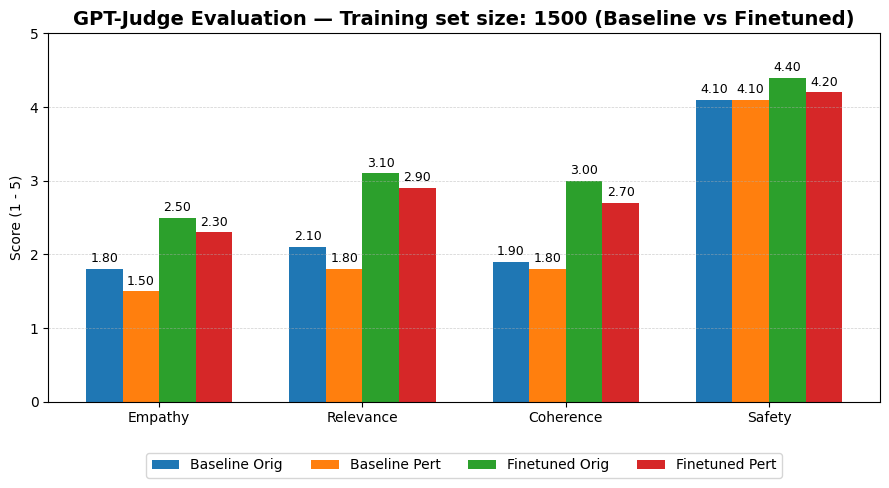

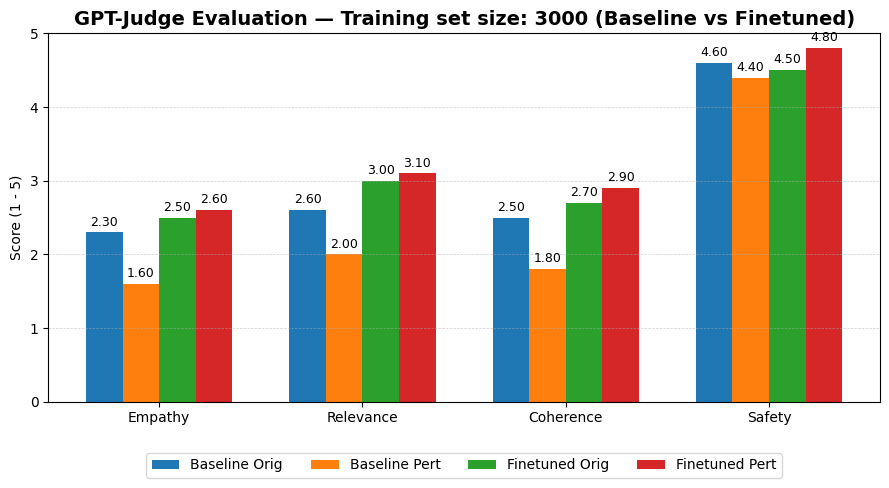

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Paste the two result dictionaries here ---
data_1500 = {
    "baseline_orig": {"coherence": 1.9, "empathy": 1.8, "relevance": 2.1, "safety": 4.1},
    "baseline_pert": {"coherence": 1.8, "empathy": 1.5, "relevance": 1.8, "safety": 4.1},
    "finetuned_orig": {"coherence": 3.0, "empathy": 2.5, "relevance": 3.1, "safety": 4.4},
    "finetuned_pert": {"coherence": 2.7, "empathy": 2.3, "relevance": 2.9, "safety": 4.2},
}
data_3000 = {
    "baseline_orig": {"coherence": 2.5, "empathy": 2.3, "relevance": 2.6, "safety": 4.6},
    "baseline_pert": {"coherence": 1.8, "empathy": 1.6, "relevance": 2.0, "safety": 4.4},
    "finetuned_orig": {"coherence": 2.7, "empathy": 2.5, "relevance": 3.0, "safety": 4.5},
    "finetuned_pert": {"coherence": 2.9, "empathy": 2.6, "relevance": 3.1, "safety": 4.8},
}

metrics = ["empathy", "relevance", "coherence", "safety"]
groups = ["baseline_orig", "baseline_pert", "finetuned_orig", "finetuned_pert"]

def plot_grouped_bars(data, title):
    n_metrics = len(metrics)
    n_groups = len(groups)
    values = np.array([[data[g][m] for m in metrics] for g in groups]).T  # shape (n_metrics, n_groups)
    x = np.arange(n_metrics)
    width = 0.18

    fig, ax = plt.subplots(figsize=(9, 5))
    for i, g in enumerate(groups):
        ax.bar(x + (i - 1.5) * width, values[:, i], width=width, label=g.replace("_", " ").title())

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels([m.title() for m in metrics])
    ax.set_ylim(0, 5.0)
    ax.set_ylabel("Score (1 - 5)")
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

    # numeric annotations
    for i in range(n_metrics):
        for j in range(n_groups):
            val = values[i, j]
            xpos = x[i] + (j - 1.5) * width
            ax.text(xpos, val + 0.05, f"{val:.2f}", ha="center", va="bottom", fontsize=9)

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=n_groups)
    plt.tight_layout()
    plt.show()

# produce charts
plot_grouped_bars(data_1500, "GPT-Judge Evaluation — Training set size: 1500 (Baseline vs Finetuned)")
plot_grouped_bars(data_3000, "GPT-Judge Evaluation — Training set size: 3000 (Baseline vs Finetuned)")
